In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
from sympy import symbols, solve
from pathlib import Path 

### Functions

In [2]:
def addTime(startDate, t): 
    dates = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = dates+ timedelta(days = t)
    return d.strftime('%Y-%m-%d')
def timeTot(startDate, endDate):
    sD = startDate.split('-')
    sDs = date(int(sD[0]),int(sD[1]),int(sD[2]))
    eD = endDate.split('-')
    eDs = date(int(eD[0]),int(eD[1]),int(eD[2]))
    delta = eDs - sDs
    return delta.days

In [3]:
def plotRealData (graph, data, offset, beforeForecast, D, minus, manipulate=False):
    if (manipulate==False):
        deaths = data["cumDeath"].tolist()
        deaths = [x-minus for x in deaths]
    else:
        deaths = data["cumDeath"]-data["cumDeath"].loc[offset]
        deaths = deaths.to_list()
        deaths = [x+minus for x in deaths]
    t = np.linspace(0, 700, 700)
    if (offset != 0):
        graph.plot(t[0:offset], deaths[0:offset], 'r', marker='.', linestyle = 'None')
        graph.plot(t[offset:beforeForecast], deaths[offset:beforeForecast], 'r', marker='x', label="Observed Data", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Data", linestyle = 'None')
    else:
        graph.plot(t[0:beforeForecast], deaths[0:beforeForecast], 'r', marker='x', label="Observed Data", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Data", linestyle = 'None')
    legend = graph.legend()
    legend.get_frame().set_alpha(0.5)
    return graph

### SIRD Model
differential equation of the SIRD model.

In [4]:
# SIRD model divided into its equations
def deriv(y, t, N, beta, gamma, rho):
    S, I, R, D= y
    dSdt = -(beta * S * I) / N
    dIdt = (beta * S * I / N) - ((gamma+rho) * I)
    dRdt = gamma * I
    dDdt = rho * I
    return dSdt, dIdt, dRdt, dDdt

In [5]:
def plotSIRD(ax, tf, N, i0, beta, gamma, rho, ylimit, xlimit, sd, offset, sird_true, name):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 


    # Plotting SIRD data point
    if (sird_true):
        ax.plot(t+offset, S, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(t+offset, I, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(t+offset, R, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.plot(t+offset, D, 'y', alpha=0.5, lw=2, label='Deceased')
    else:
        ax.plot(t+offset, D, alpha=1, lw=2, label=name)


    # Creating Labels for graph
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Deceased')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    ax.set_xlim([xlimit[0], xlimit[1]])
    ax.set_ylim([ylimit[0], ylimit[1]])
    ax.set_label(name)
    # ax.fill_between(t+offset, Dm, Dp, alpha=0.2, edgecolor='black',  label="Standard Deviation")
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    return D

In [6]:
dataset = {
    'Switzerland' : {
        'data' : pd.read_csv("../processed_data/cumDeathSwitzerland.csv"),
        'fLock' : ['2020-03-17', '2020-04-27'],
        'sLock' : ['2021-01-18', '2021-03-01'],
        'pop' : 8570146
            },
        'Sweden' : {
        'data' : pd.read_csv("../processed_data/cumDeathSweden.csv"),
        'fLock' : ['2020-03-15', '2020-04-06'],
        'sLock' : ['2020-12-15', '2021-06-05'],
        'pop' : 10420000
            }
}

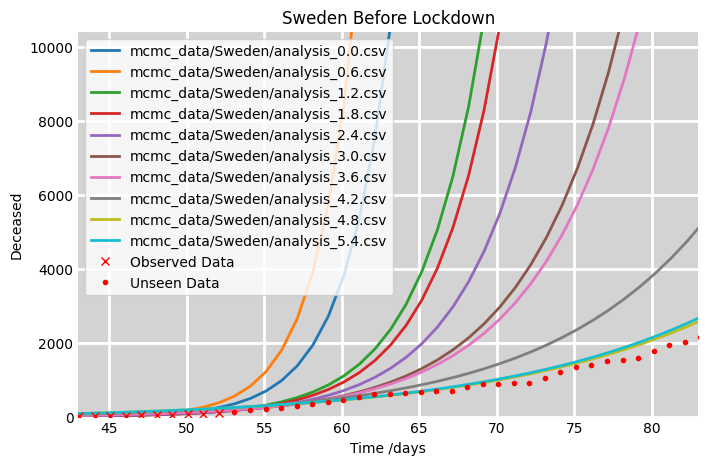

In [69]:
country_names = ['Sweden']
sird_deaths = {}
fildesDir = "mcmc_data/Sweden/"
country = "Sweden"
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
ax1.set_facecolor('lightgrey')
r_sweden = []
file_list = [str(x) for x in Path(fildesDir).rglob('analysis_*.csv')]
file_list.sort()
for file in file_list:
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']


    obvData_start = timeTot(firstDate,startDate)
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    add = dataset[country]['data'].iloc[[obvData_start]]['cumDeath']
    df = pd.read_csv(file)
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False, file)
    r_sweden.append(df.loc[4][1])

final_graph =plotRealData(ax1, realData, obvData_start, obvData_end-10, graph,0)
ax1.set_title(country + " Before Lockdown")
ax1.legend()
plt.savefig('results/sweden_analysis/'+country+'.png')

['mcmc_data/Switzerland/analysis_0.0.csv', 'mcmc_data/Switzerland/analysis_0.6.csv', 'mcmc_data/Switzerland/analysis_1.2.csv', 'mcmc_data/Switzerland/analysis_1.8.csv', 'mcmc_data/Switzerland/analysis_2.4.csv', 'mcmc_data/Switzerland/analysis_3.0.csv', 'mcmc_data/Switzerland/analysis_3.6.csv', 'mcmc_data/Switzerland/analysis_4.2.csv', 'mcmc_data/Switzerland/analysis_4.8.csv', 'mcmc_data/Switzerland/analysis_5.4.csv']
mcmc_data/Switzerland/analysis_0.0.csv
mcmc_data/Switzerland/analysis_0.6.csv
mcmc_data/Switzerland/analysis_1.2.csv
mcmc_data/Switzerland/analysis_1.8.csv
mcmc_data/Switzerland/analysis_2.4.csv
mcmc_data/Switzerland/analysis_3.0.csv
mcmc_data/Switzerland/analysis_3.6.csv
mcmc_data/Switzerland/analysis_4.2.csv
mcmc_data/Switzerland/analysis_4.8.csv
mcmc_data/Switzerland/analysis_5.4.csv


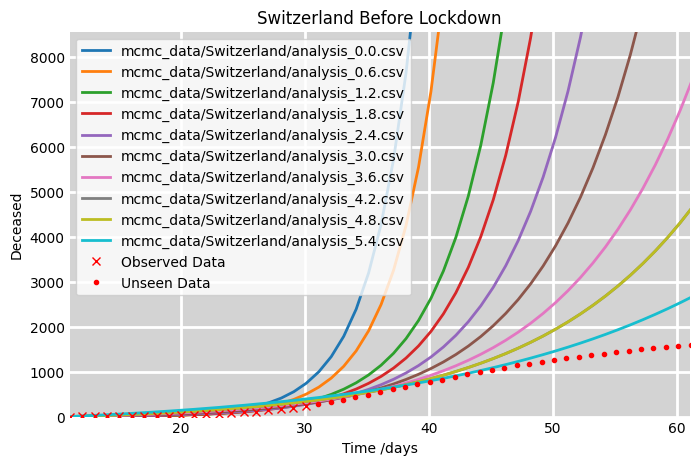

In [67]:
country_names = ['Switzerland']
sird_deaths = {}
fildesDir = "mcmc_data/Switzerland/"
country = "Switzerland"
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
ax1.set_facecolor('lightgrey')
r_swiss = []
file_list = [str(x) for x in Path(fildesDir).rglob('analysis_*.csv')]
file_list.sort()
print(file_list)
for file in file_list:
    print(file)
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    obvData_start = timeTot(firstDate,startDate)-10
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    add = dataset[country]['data'].iloc[[obvData_start]]['cumDeath']
    df = pd.read_csv(file)
    r_swiss.append(df.loc[4][1])
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False, file)

final_graph =plotRealData(ax1, realData, obvData_start, obvData_end-10, graph,0)
ax1.set_title(country + " Before Lockdown")
ax1.legend()
plt.savefig('results/sweden_analysis/'+country+'.png')

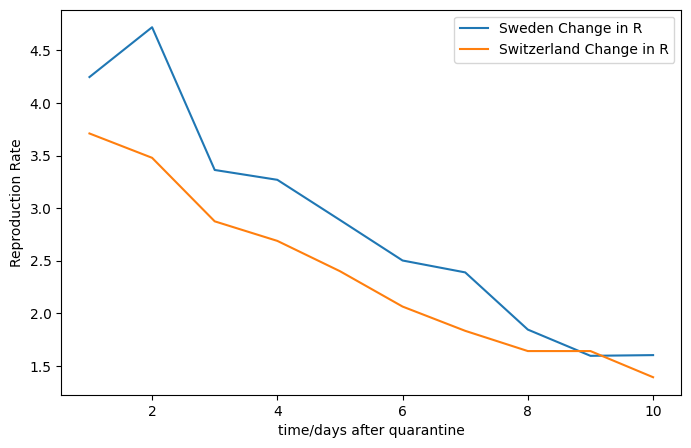

In [73]:
x = np.linspace(1,10,10)
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
ax1.plot(x,r_sweden, label="Sweden Change in R")
ax1.plot(x,r_swiss, label="Switzerland Change in R")
ax1.set_xlabel("time/days after quarantine")
ax1.set_ylabel("Reproduction Rate")
ax1.legend()